# Bivariate analysis


The objective of this notebook is to analyze each variable vs. the target to understand patterns, associations, and potential causal relationships between the variables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency, ks_2samp, anderson
import statsmodels.api as sm
from statsmodels.formula.api import ols
import category_encoders as ce

import os
import sys 
import warnings
import pickle
import config
from IPython.display import Image

from utils import load_from_pickle, save_to_pickle

warnings.filterwarnings("ignore")

images_directory = 'images/images_bivar_analysis'
os.makedirs(images_directory, exist_ok=True)

pickle_directory = 'variables/variables_bivar_analysis'
os.makedirs(pickle_directory, exist_ok=True)

src added to sys.path: /home/maldu/dscience/projects/fraud_detection/src


In [2]:
data = pd.read_parquet('../data/silver/df_fraud_univar.parquet', engine= 'fastparquet')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud,1,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud,1,1.000-10.000
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,fraud,1,0-1.000
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,fraud,1,0-1.000
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud,1,10.000-100.000


## step & day_of_month vs. isFraud

### Step

#### Statistical tests

Is there a difference in the measures or distributions of the variable 'step' between the two groups defined by the target variable? I can plot it, sure, but I will also apply some statistical analysis to represent the difference between both groups.


I use the Mann-Whitney U Test because the variable 'step' doesn't follow a normal distribution. This test is suitable for comparing the central tendency of step between fraudulent and non-fraudulent transactions.

In [3]:
group1 = data[data['isFraud'] == 'fraud']['step']
group2 = data[data['isFraud'] == 'no_fraud']['step']

stat, p_value = mannwhitneyu(group1, group2)

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p_value}")

Mann-Whitney U Statistic: 34829829709.5
P-Value: 0.0


- Mann-Whitney U Statistic: 34829829709'5. The U statistic measures the difference between distributions. The bigger the U, the greater the difference but this value doesn't show anything by itself. I need to consider it after paying attention to the p-value.

- p-value = 0 so there is a significative statistical difference of 'step' between the two catories of 'isFraud'. The variable 'step' behaves differently in each group.

---

But as we saw in the univariate analysis our independent variable is VERY unbalanced and this can affect statistical results with any test:

isFraud
- no_fraud    6354407
- fraud          8213

isFraud
- no_fraud    99.871%
- fraud        0.129%

Multiple tests increase the robustness of our conclusions. If different tests lead to similar results, I can be more confident in my findings. The Kolmogorov-Smirnov Test can be useful when we can't assume normality and it's suitable for comparing the overall distribution of step between fraudulent and non-fraudulent transactions.

In [4]:
ks_stat, ks_p_value = ks_2samp(group1, group2)

print(f"KS Statistic: {ks_stat}")
print(f"P-Value: {ks_p_value}")

KS Statistic: 0.38321211884693807
P-Value: 0.0


- KS Statistic = 0.38 means that there is a difference of the 38% in some point of the CDF (Cumulative Distribution Function) = clear discrepancy between distributions

- p-value = 0, same conclusion as before

#### Summary stats

In [5]:
data.groupby('isFraud')['step'].describe()


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
fraud,8213.0,368.413856,216.388690,1.0,181.0,367.0,558.0,743.0
no_fraud,6354407.0,243.235663,142.140194,1.0,156.0,239.0,334.0,718.0


#### Visualization

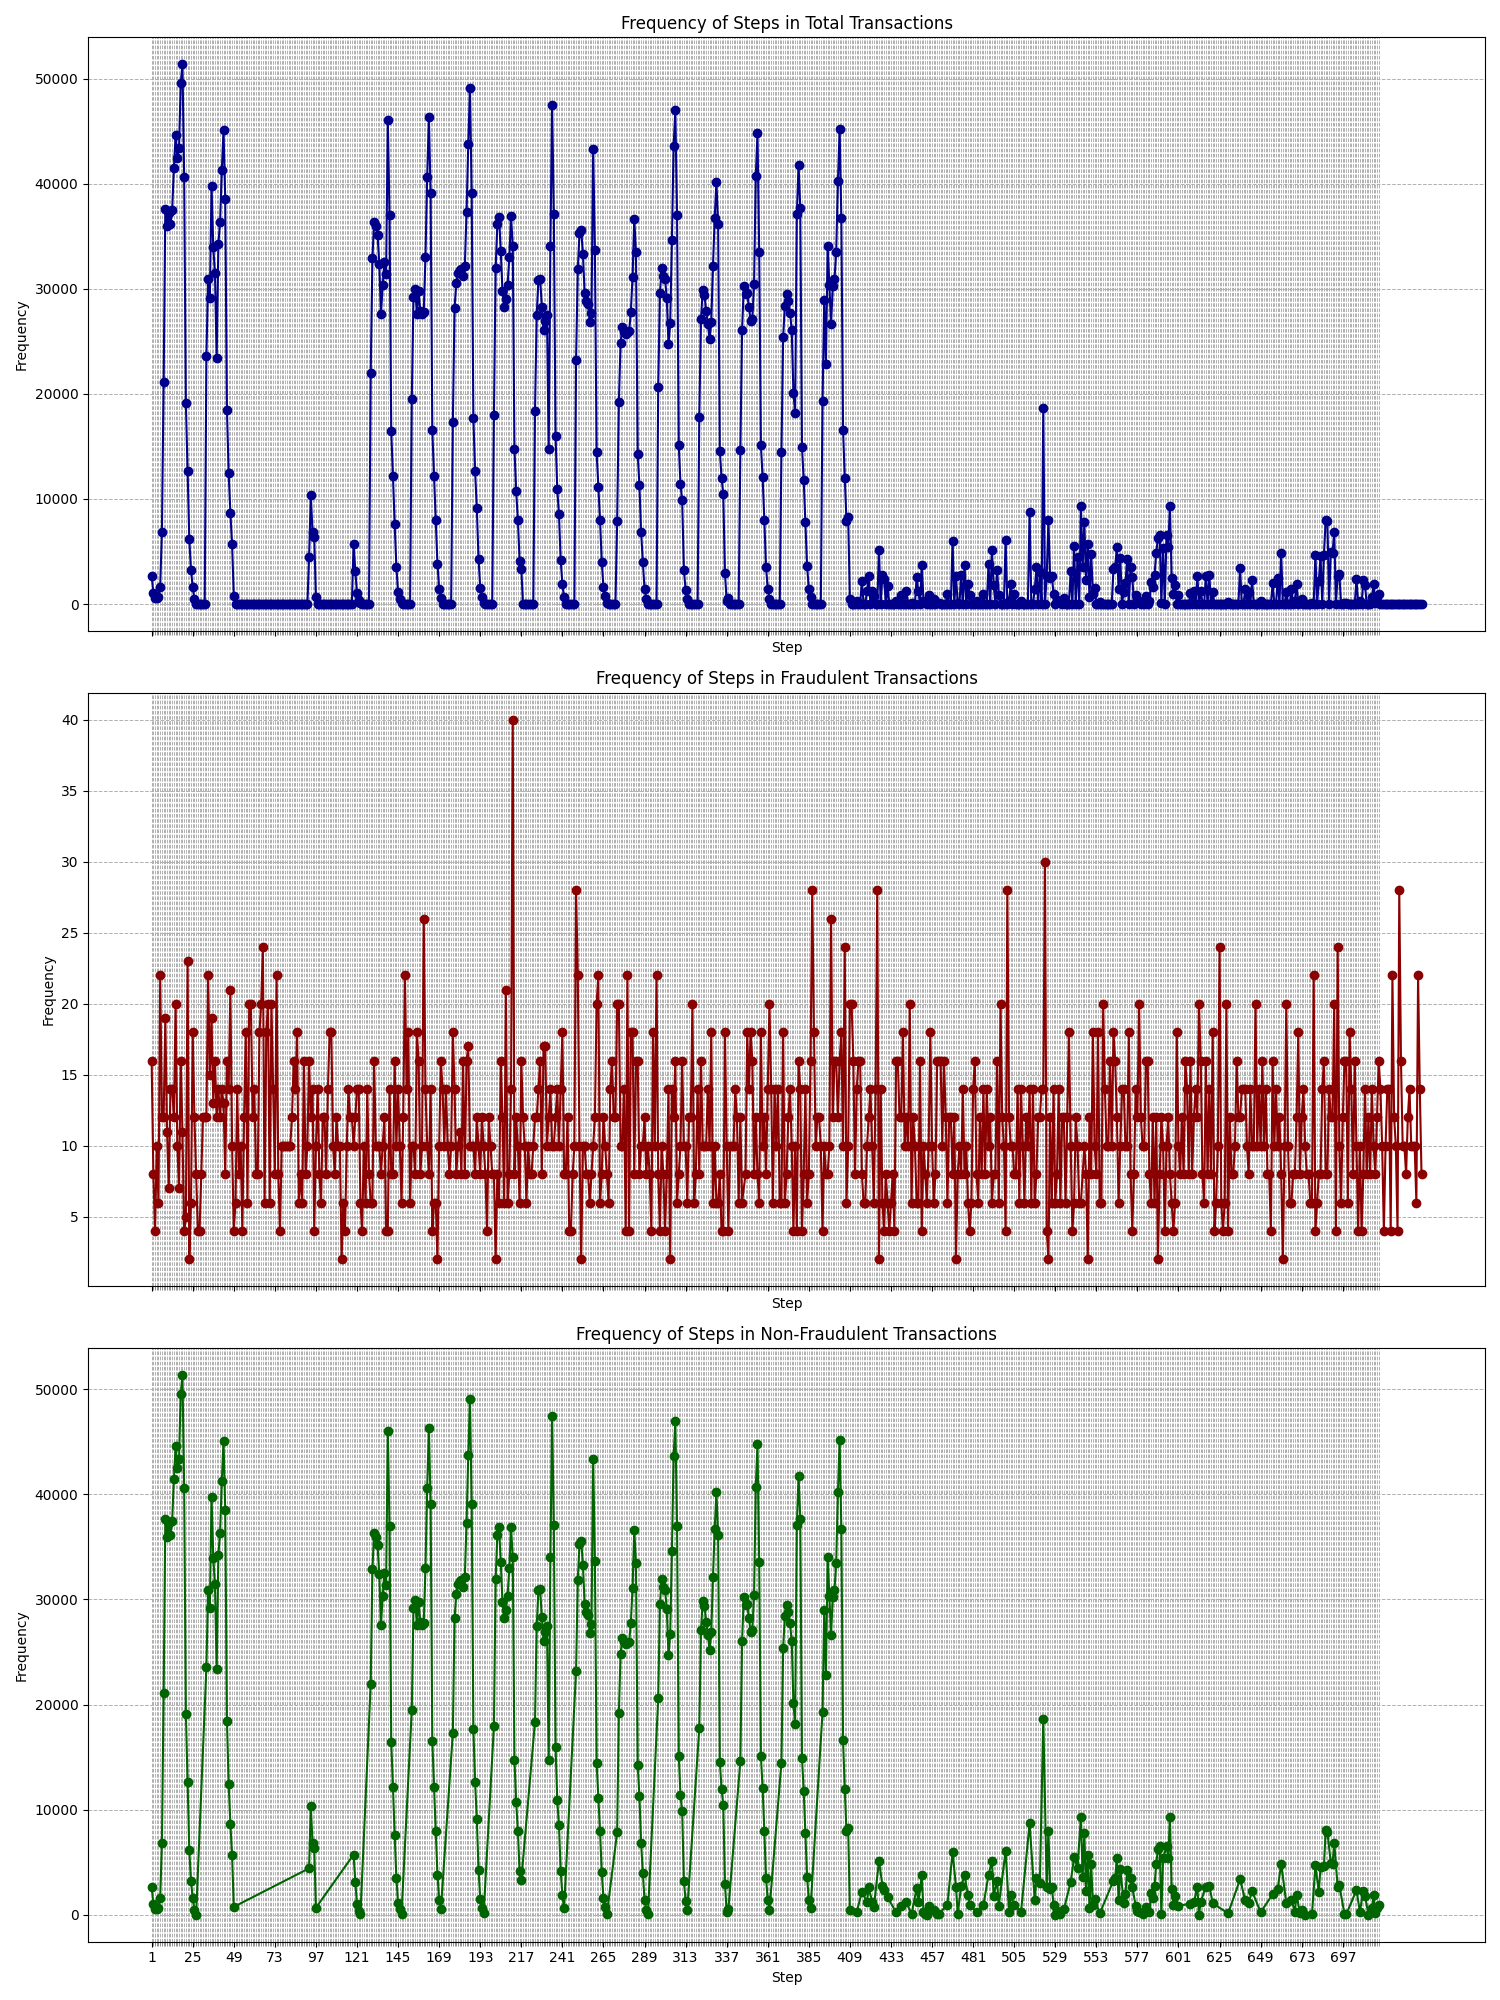

In [6]:
image_filename = 'lineplot_step_vs_fraud.png'
plot_filepath = os.path.join(images_directory, image_filename)

if not os.path.isfile(plot_filepath):
    total_value_counts = data['step'].value_counts().sort_index()
    fraud_value_counts = data[data['isFraud'] == 'fraud']['step'].value_counts().sort_index()
    non_fraud_value_counts = data[data['isFraud'] == 'no_fraud']['step'].value_counts().sort_index()

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20), sharex=True)

    titles = [
        "Frequency of Steps in Total Transactions", 
        "Frequency of Steps in Fraudulent Transactions", 
        "Frequency of Steps in Non-Fraudulent Transactions"
    ]
    colors = ['#00008B', '#8B0000', '#006400']
    counts_list = [total_value_counts, fraud_value_counts, non_fraud_value_counts]

    for ax, counts, title, color in zip(axes, counts_list, titles, colors):
        ax.plot(counts.index, counts, marker='o', color=color, linestyle='-', markersize=6)
        ax.set_title(title)
        ax.set_xlabel("Step")
        ax.set_ylabel("Frequency")
        ax.grid(True, which='both', linestyle='--', linewidth=0.7)
        ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 24)) 
        ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 1), minor=True)  
        ax.tick_params(axis='x', which='minor', length=3, color='grey')

    plt.tight_layout()
    plt.savefig(plot_filepath)  
    plt.close(fig)  

Image(filename=plot_filepath)

In [7]:
#TODO - fix x axis and x labels (de 24 en 24)

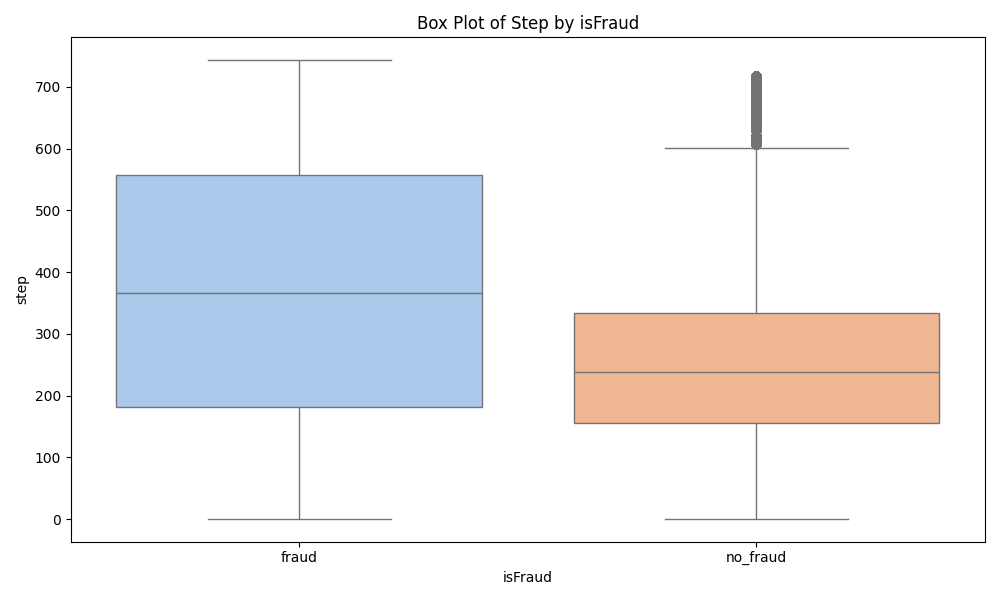

In [8]:
image_filename = 'boxplot_step_vs_fraud.png'
plot_filepath = os.path.join(images_directory, image_filename)

if not os.path.isfile(plot_filepath):
    plt.figure(figsize=(10, 6))  
    sns.boxplot(x='isFraud', y='step', data=data, palette='pastel')
    plt.title('Box Plot of Step by isFraud')

    plt.tight_layout()
    plt.savefig(plot_filepath)  
    plt.close()  

Image(filename=plot_filepath)

Observations:

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

Non-fraudulent transactions vary over time, fraudulent transactions remain constant.


Non-fraudulent transactions happen inside defined step ranges and slow down when the step is a bit higher than 400 (15 days aprox). 
- The first step range makes sense since people get their salaries at the beginning of the month. 
- The second step range, as I said in the univariate analysis notebook doesn't make sense to me. In this case it would be helpful to know, for example, which month of the year it is to understand if there is any special event in the middle of the month that made people use more transactions.
- There is a gap between the first 48 and 120 hours. It would be interesting to get more information about the month, year, country from where the transaction was sent/received. Was it a bank holiday so people would be on holidays? 

Fraudulent transactions stay constant along the step range. That means fraudsters behaviour stays constant all over the month. 
- There is also a step with very high frequency between the steps 193 and 217.
- Fraudsters usually take very short time to process the transaction so it would be also nice to obtain data about the amount of time spent on the merchants website, the time used by the client to confirm the transaction (short times can indicate that a bot is actually using the platform), etc.

---



#### Additional analysis

What is happening in the very frequent step? How is the relationship between that step and fraud?

In [9]:
contingency_table = pd.crosstab(data['step'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100

contingency_table.loc[(contingency_table.index > 193) & (contingency_table.index < 220)]

isFraud,fraud,no_fraud,total,fraud_proportion
step,,,,
194,12,659,671,1.788376
195,10,131,141,7.092199
196,8,0,8,100.000000
197,4,0,4,100.000000
198,12,0,12,100.000000
199,10,0,10,100.000000
200,8,0,8,100.000000
201,8,17955,17963,0.044536
202,2,31947,31949,0.006260


Observations:

There are far more fraudulent transactions on the step 212. 212 steps = 8 days + 20h.
- Why so many people are commiting fraud that day? Why at that time? Was it a coincidence? 
- Was it Black Friday or maybe another special day where a website makes offers?
Time to ask what could have happened here from a business perspective and check the characteristics of those transactions.


The are also other picks on the fraudulent transactions that could be analysed along the gaps of days between them even though the amount of fraud transactions are very constant over time. 


----

Are night transactions more likely to be fraudulent? 

In [10]:
time_data = data[['step', 'day_of_month', 'isFraud']].copy()
time_data['hour_of_day'] = data['step'] % 24
time_data

,step,day_of_month,isFraud,hour_of_day
0,1,1,no_fraud,1
1,1,1,no_fraud,1
2,1,1,fraud,1
3,1,1,fraud,1
4,1,1,no_fraud,1
...,...,...,...,...
6362615,743,31,fraud,23
6362616,743,31,fraud,23
6362617,743,31,fraud,23
6362618,743,31,fraud,23


In [11]:
count_hours = time_data.groupby(['hour_of_day']).agg(
    count_fraud=pd.NamedAgg(column='isFraud', aggfunc=lambda x: (x == 'fraud').sum()),
    count_no_fraud=pd.NamedAgg(column='isFraud', aggfunc=lambda x: (x == 'no_fraud').sum())
    
).reset_index()

count_hours    

,hour_of_day,count_fraud,count_no_fraud
0,0,300,71287
1,1,358,26753
2,2,372,8646
3,3,326,1681
4,4,274,967
5,5,366,1275
6,6,358,3062
7,7,328,8660
8,8,368,26547
9,9,341,283177


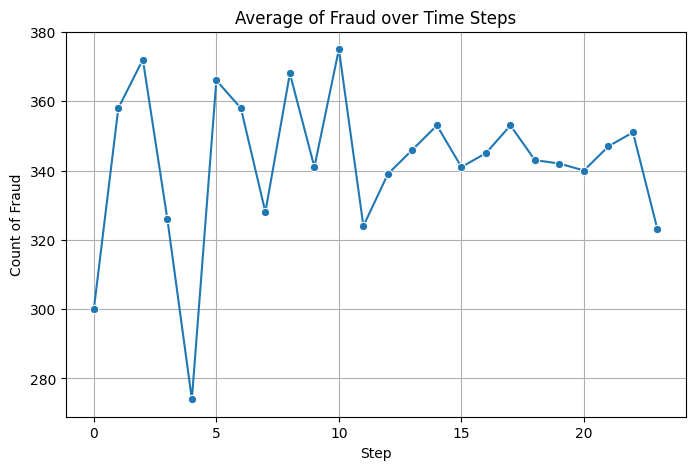

In [12]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=count_hours, x='hour_of_day', y='count_fraud', marker='o')
plt.xlabel('Step')
plt.ylabel('Count of Fraud')
plt.title('Average of Fraud over Time Steps')
plt.grid()
plt.show()

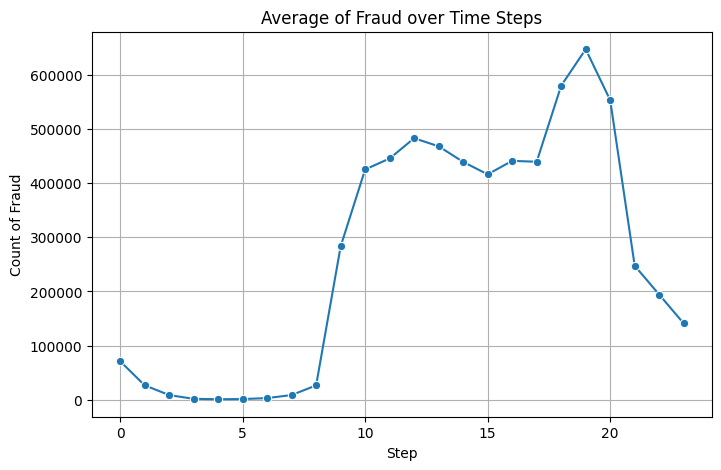

In [13]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=count_hours, x='hour_of_day', y='count_no_fraud', marker='o')
plt.xlabel('Step')
plt.ylabel('Count of Fraud')
plt.title('Average of Fraud over Time Steps')
plt.grid()
plt.show()

Observations: 

The frequency of fraudulent transactions stay constant, but in the non-fraudulent transactions goes down during the night.

---


### Day of the Month

#### Statistical tests

I don't perform statistical tests because the transformation applied to the variable 'step' to become 'day_of_the_moth' slightly changes the distribution but not enough to be considered normal (check skewness, kurtosis and the plot in the following section)

#### Summary stats


In [14]:
data.groupby('isFraud')['day_of_month'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
fraud,8213.0,15.832948,9.017848,1.0,8.0,16.0,24.0,31.0
no_fraud,6354407.0,10.485004,5.913643,1.0,7.0,10.0,14.0,30.0


#### Visualization

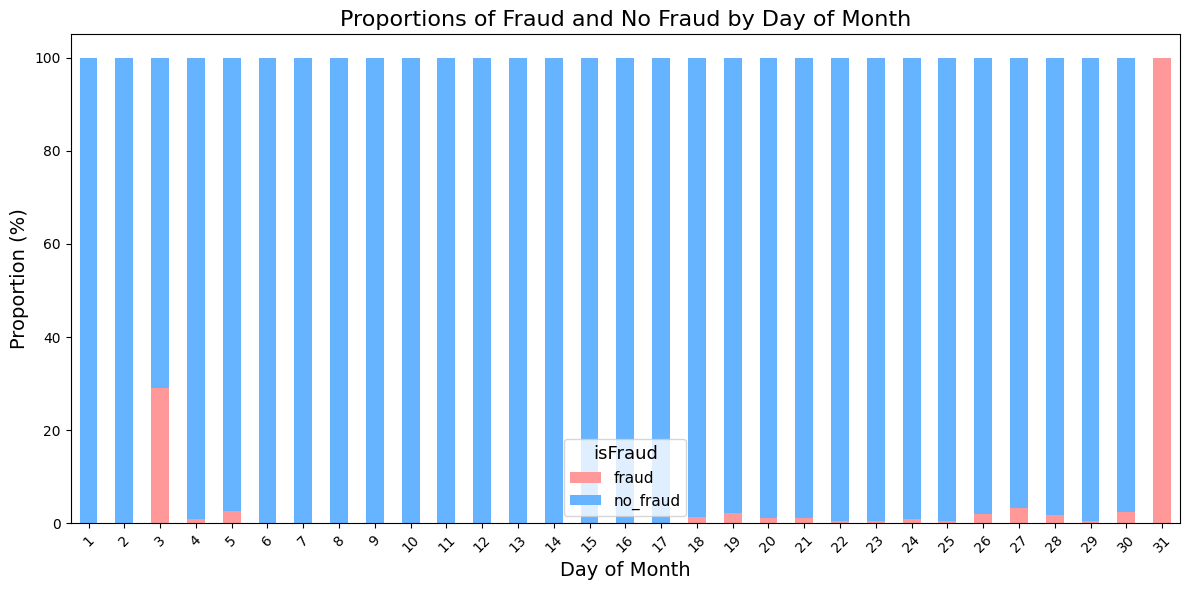

In [15]:
contingency_table = time_data.groupby(['day_of_month', 'isFraud'], observed=True).size().unstack(fill_value=0)
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
proportions.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], ax=plt.gca())
plt.title('Proportions of Fraud and No Fraud by Day of Month', fontsize=16)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Proportion (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='isFraud', title_fontsize='13', fontsize='11')
plt.tight_layout()

plt.show()

Observations:

- The last day of the month has only fraudulent transactions. Curious, right? I would need more info about the context but it looks like it's a coincidence.
- In the same days where non fraudulent transactions (remember we had the hypothesis that it would may be )
Besides that I don't see any clear pattern.

#### Additional analysis

In [16]:
contingency_table = pd.crosstab(data['day_of_month'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100
contingency_table

isFraud,fraud,no_fraud,total,fraud_proportion
day_of_month,,,,
1,271,573984,574255,0.047192
2,309,454929,455238,0.067877
3,310,760,1070,28.971963
4,262,27978,28240,0.927762
5,252,9537,9789,2.574318
6,228,440777,441005,0.051700
7,272,420311,420583,0.064672
8,278,449359,449637,0.061828
9,255,417664,417919,0.061017


Observations:

- I can see the same pattern again, the days 3,4,5 vary from the rest. I assume this could be a bank holiday or another special day but I don't have enough information, like the month of the year, to explain that behavior. 

- Again the last day of the month only has fraudulent transactions.

## type vs. isFraud

#### Statistical tests

In [17]:
contingency_table = pd.crosstab(data['type'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
type,,
CASH_IN,0,1399284
CASH_OUT,4116,2233384
DEBIT,0,41432
PAYMENT,0,2151495
TRANSFER,4097,528812


ANOVA test converting the variable 'isFraud' to numerical since chi-square test needs higher frequency in the categories

In [18]:
df = data.copy()
df['isFraud'] = df['isFraud'].replace({'no_fraud':0, 'fraud':1})
df['isFraud'] = df['isFraud'].astype(int) 
df

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,0,1,1.000-10.000
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,0,1,1.000-10.000
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,1,1,0-1.000
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,1,1,0-1.000
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,0,1,10.000-100.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,1,31,100.000-1.000.000
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,1,31,1.000.000-10.000.000
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,1,31,1.000.000-10.000.000
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,1,31,100.000-1.000.000


In [19]:
model = ols('isFraud ~ C(type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(type),28.467794,4.0,5539.856588,0.0
Residual,8173.930697,6362615.0,NaN,NaN


Observations:

- The large F-statistic (5539.856588) supports the conclusion that the variability between the means of different type categories is significantly greater than the variability within the groups.

- The p-value is extremely small (effectively 0), indicating that the differences in the means of isFraud across different type categories are statistically significant.

#### Summary stats

In [20]:
data.groupby('isFraud')['type'].describe()

,count,unique,top,freq
isFraud,,,,
fraud,8213,2,CASH_OUT,4116
no_fraud,6354407,5,CASH_OUT,2233384


Observations:

The only types that have fraudulent transactions are CASH_OUT and TRANSFER and as we saw in the univariate analysis they are substantially less common

#### Visualization

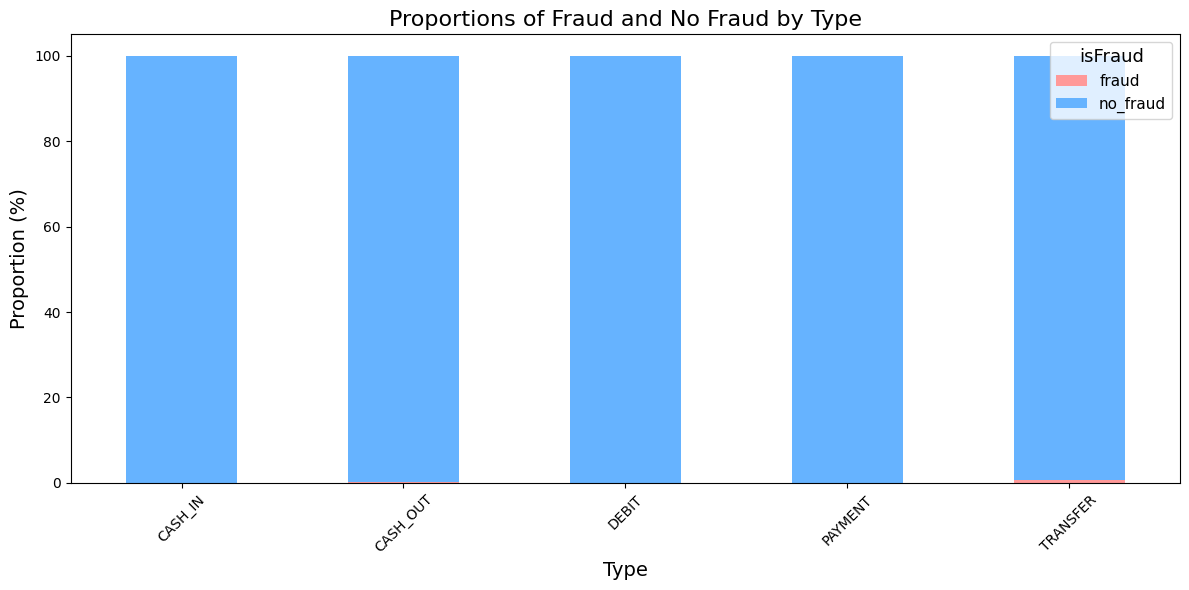

In [21]:
contingency_table = data.groupby(['type', 'isFraud'], observed=True).size().unstack(fill_value=0)
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
proportions.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], ax=plt.gca())
plt.title('Proportions of Fraud and No Fraud by Type', fontsize=16)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Proportion (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='isFraud', title_fontsize='13', fontsize='11')
plt.tight_layout()

plt.show()

In [22]:
contingency_table

isFraud,fraud,no_fraud
type,,
CASH_IN,0,1399284
CASH_OUT,4116,2233384
DEBIT,0,41432
PAYMENT,0,2151495
TRANSFER,4097,528812


Observations:

- CASH_IN, DEBIT, PAYMENT have 0 fraud records. 
- CASH_OUT means withdrawing money from the ATM, probably by copying your credit card, a typical fraud strategy I even suffered.
- TRANSFER means that the fraudsters had access to the personal data from the customers? I need more business information to understand the way this fraud is done.

## amount_range & amount vs. isFraud

### amount_range

#### Statistical tests

In [23]:
model = ols('isFraud ~ C(amount_range)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(amount_range),57.111233,5.0,8922.379697,0.0
Residual,8145.287259,6362614.0,NaN,NaN


Observations:

- The large F-statistic (8922.379697) supports the conclusion that the variability between the means of different type categories is significantly greater than the variability within the groups.

- The p-value is extremely small (effectively 0), indicating that the differences in the means of isFraud across different type categories are statistically significant.


#### Summary stats

In [24]:
data.groupby('isFraud')['amount_range'].describe()

,count,unique,top,freq
isFraud,,,,
fraud,8213,6,100.000-1.000.000,3800
no_fraud,6354407,6,100.000-1.000.000,2702938


Observations:

- The range of 100.000-1.000.000 has most of both fraudulent and non-fraudulent transactions 

In [25]:
contingency_table = pd.crosstab(data['amount_range'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
amount_range,,
0-1.000,58,142584
1.000-10.000,220,1143141
10.000-100.000,1429,2237824
100.000-1.000.000,3800,2702938
1.000.000-10.000.000,2419,122557
10.000.000-100.000.000,287,5363


#### Visualization

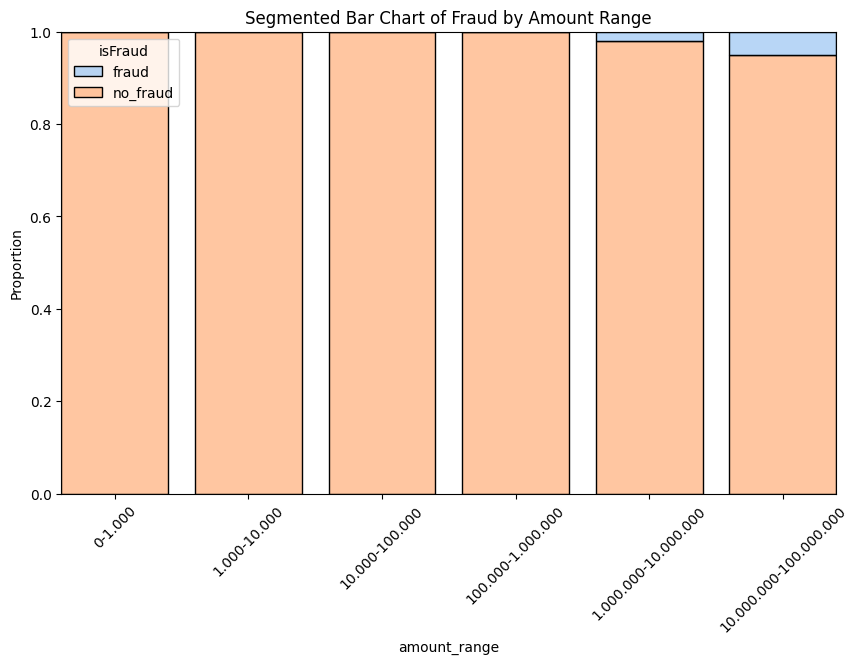

In [26]:
plt.figure(figsize=(10, 6))
segmented_bar = sns.histplot(
    data=data,
    x="amount_range", 
    hue="isFraud", 
    multiple="fill", 
    shrink=0.8,
    palette = 'pastel'
    
)
plt.xticks(rotation=45)
segmented_bar.set(ylabel="Proportion")
plt.title('Segmented Bar Chart of Fraud by Amount Range')
plt.show()

Observations:

From the crosstab, we can see that the amount ranges between 10k and 10M are the ones with most fraudulent transactions but the proportions show that highest values will have more probability to be fraudulent.

We have to remember that bins have not the same size

### amount

##### Statistical tests

In [27]:
group1 = data[data['isFraud'] == 'fraud']['amount']
group2 = data[data['isFraud'] == 'no_fraud']['amount']

stat, p_value = mannwhitneyu(group1, group2)

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p_value}")

Mann-Whitney U Statistic: 41224999623.5
P-Value: 0.0


- p-value = 0 so there is a significative statistical difference of 'amount' between the two catories of 'isFraud'. The variable 'amount' behaves differently in each group.

- Mann-Whitney U Statistic: 41224999623.5. The range between both groups is very huge. 


##### Summary stats

In [28]:
data.groupby('isFraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
fraud,8213.0,1.467967e+06,2404253.0,0.00,127091.328125,441423.43750,1.517772e+06,10000000.0
no_fraud,6354407.0,1.781970e+05,596237.0,0.01,13368.395020,74684.71875,2.083648e+05,92445520.0


Observations:

- The average amount of fraudulent transactions is much higher than that of non-fraudulent transactions so fraudulent transactions tend to involve larger amounts of money.

- The standard deviation is also much higher for fraudulent transactions, the presence of some very high-value fraudulent transactions.

- The 25th percentile value for fraudulent transactions is significantly higher, indicating that even the smaller fraudulent transactions tend to involve more money than the non-fraudulent transactions.

- The median amount for fraudulent transactions is substantially higher than for non-fraudulent transactions. Half of the fraudulent transactions are below approximately 441,423, while half of the non-fraudulent transactions are below approximately 74,685.

- The 75th percentile value for fraudulent transactions is much higher, indicating that a significant portion of fraudulent transactions are of very high value compared to non-fraudulent ones.

- Non-fraudulent transactions are far more numerous and have a wider range of amounts, but their typical transaction amounts are much smaller than those of fraudulent transactions.

##### Visualization

In [29]:
contingency_table_amounts = pd.crosstab(data['amount'], data['isFraud'])
contingency_table_amounts

isFraud,fraud,no_fraud
amount,,
0.00,16,0
0.01,0,1
0.02,0,3
0.03,0,2
0.04,0,1
...,...,...
69337320.00,0,1
69886728.00,0,1
71172480.00,0,1


In [30]:
contingency_table_amounts[contingency_table_amounts['fraud'] > 2]

isFraud,fraud,no_fraud
amount,,
0.000000e+00,16,0
4.292574e+05,4,0
1.165188e+06,4,0
1.000000e+07,287,2920


Observations: 

- I have the hypothesis that humans usually work with rounded values. There is a huge number of fraud transactions moving 1.000000e+07€. It would be interesting to continue doing research on transactions with rounded amounts.

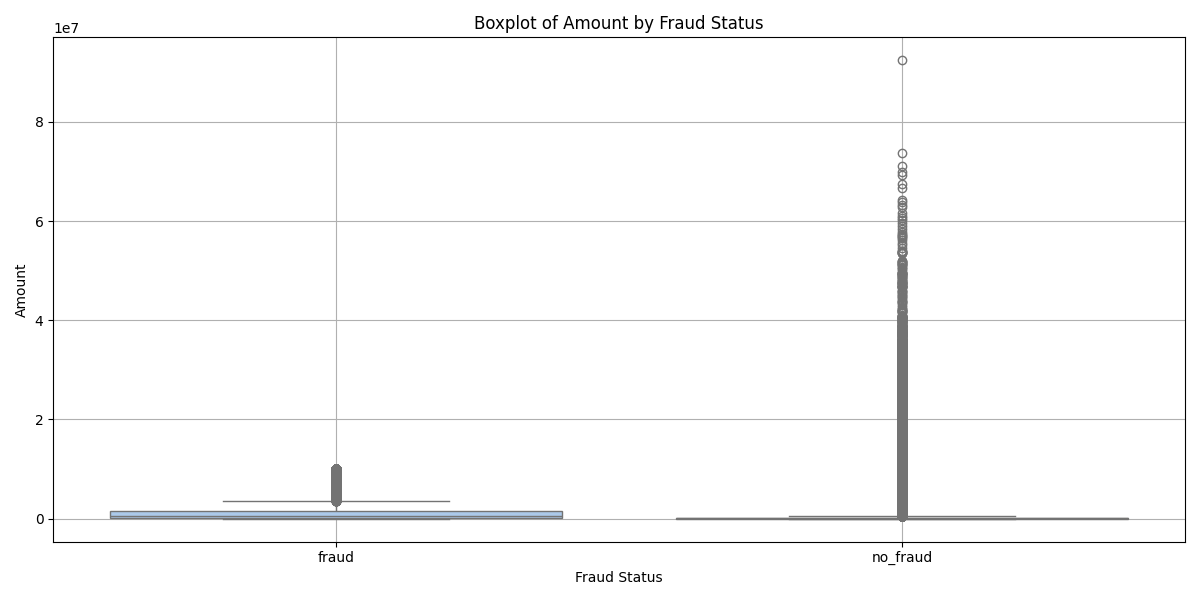

In [31]:
image_filename = 'boxplot_amount_vs_fraud.png'
plot_filepath = os.path.join(images_directory, image_filename)
    
if not os.path.isfile(plot_filepath):
    fig = plt.figure(figsize=(12, 6))
    boxplot = sns.boxplot(x='isFraud', y='amount', data=data, palette='pastel')
    plt.title('Boxplot of Amount by Fraud Status')
    plt.xlabel('Fraud Status')
    plt.ylabel('Amount')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plot_filepath)  
    plt.close(fig)  


Image(filename=plot_filepath)

##### Additional analysis

Which are the characteristics of the transactions with amount = 0?

In [32]:
data.query('amount == 0')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.000000e+00,0.000000e+00,fraud,9,0-1.000
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.000000e+00,0.000000e+00,fraud,11,0-1.000
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,5.385476e+05,5.385476e+05,fraud,12,0-1.000
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7.970766e+06,7.970766e+06,fraud,17,0-1.000
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,7.675990e+04,7.675990e+04,fraud,18,0-1.000
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2.921531e+06,2.921531e+06,fraud,18,0-1.000
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,2.302897e+05,2.302897e+05,fraud,24,0-1.000
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1.328473e+06,1.328473e+06,fraud,25,0-1.000
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.000000e+00,0.000000e+00,fraud,26,0-1.000
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.000000e+00,0.000000e+00,fraud,27,0-1.000


Observations:

Withrawals with amount = 0 are fraudulent, none of them is repeated and they have been used to try to withdraw money. We could analyze the origin and destination users and see their behaviour. One example could be using the postal code, the IP data, the account age, etc. to find hidden patterns.

---

Is there a more frequent amount of money that fraudsters prefer to work with?

In [33]:
pickle_filename = 'repeated_amounts.pkl'
pickle_filepath = os.path.join(pickle_directory, pickle_filename)

is_cached = False
try:
    repeated_amounts = load_from_pickle(pickle_filepath)
    is_cached = True
except FileNotFoundError:
    is_cached = False

if is_cached:
    print("The DataFrame is already stored in cache")
else:
    print("DataFrame not found. Calculating...")

    repeated_rows = data[data.duplicated('amount', keep=False) & (data['amount'] != 0)]

    repeated_amounts = (repeated_rows.groupby('amount')
                        .agg(count_is_not_Fraud=('isFraud', lambda x: (x == 'no_fraud').sum()),
                             count_isFraud=('isFraud', lambda x: (x == 'fraud').sum()),
                             percentage_is_not_Fraud=('isFraud', lambda x: round((x == 'no_fraud').mean() * 100, 2)),
                             percentage_isFraud=('isFraud', lambda x: round((x == 'fraud').mean() * 100, 2)))
                        .reset_index())

    save_to_pickle(repeated_amounts, pickle_filepath)

repeated_amounts

The DataFrame is already stored in cache


,amount,count_is_not_Fraud,count_isFraud,percentage_is_not_Fraud,percentage_isFraud
0,0.02,3,0,100.00,0.00
1,0.03,2,0,100.00,0.00
2,0.11,2,0,100.00,0.00
3,0.14,2,0,100.00,0.00
4,0.18,2,0,100.00,0.00
...,...,...,...,...,...
851675,9960382.00,0,2,0.00,100.00
851676,9977761.00,0,2,0.00,100.00
851677,9996887.00,0,2,0.00,100.00
851678,10000000.00,2920,287,91.05,8.95


In [34]:
repeated_amounts.query("count_isFraud > 2")


,amount,count_is_not_Fraud,count_isFraud,percentage_is_not_Fraud,percentage_isFraud
842753,4.292574e+05,0,4,0.00,100.00
850223,1.165188e+06,0,4,0.00,100.00
851678,1.000000e+07,2920,287,91.05,8.95


Most amounts are repeated 2 times. There are only 3 that are repeated more than 2 times. Further analysis could be focused on analysing the characteristics of those accounts. 

---
I have another question that I will leave for a possible further analysis:

- Since humans are more likely to understand and work with integer amounts, are they more prone to reflect fraudulent transactions? 


## nameOrig vs. isFraud

### Statistical tests

In [35]:
print(f'The number of unique values in the column is: {data["nameOrig"].nunique()}')
print(f'The total length of the column is: {len(data["nameOrig"])}')


The number of unique values in the column is: 6353307
The total length of the column is: 6362620


Observations:

There are too many unique values in this column. It does not make sense to test the column.

In [36]:
data['nameOrig'].value_counts()

nameOrig
C363736674     3
C724452879     3
C2051359467    3
C1976208114    3
C2098525306    3
              ..
C1645324143    1
C1645323789    1
C1645322804    1
C1645322647    1
C1645327442    1
Name: count, Length: 6353307, dtype: int64

### Summary stats

In [37]:
data.groupby('isFraud')['nameOrig'].describe()

,count,unique,top,freq
isFraud,,,,
fraud,8213,8213,C1652159172,1
no_fraud,6354407,6345122,C2051359467,3


Observations:

- Frequency in fraudulent transactions shows that accounts are always used once.

In [38]:
contingency_table = pd.crosstab(data['nameOrig'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
nameOrig,,
C1000000639,0,1
C1000001337,0,1
C1000001725,0,1
C1000002591,0,1
C1000003372,0,1
...,...,...
C999996999,0,1
C999998175,0,1
C999999254,0,1


### Additional analysis

In [39]:
nameOrig_counts = data['nameOrig'].value_counts()

nameOrig_gt3 = nameOrig_counts[nameOrig_counts == 3].index
subset_3 = data[data['nameOrig'].isin(nameOrig_gt3)]
subset_3.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
48162,9,CASH_OUT,280613.062500,C2098525306,2.027100e+05,0.000000e+00,C1601211078,1624635.500,2.342233e+06,no_fraud,1,100.000-1.000.000
53297,9,PAYMENT,2142.129883,C400299098,9.110515e+04,8.896302e+04,M885272395,0.000,0.000000e+00,no_fraud,1,1.000-10.000
195150,13,PAYMENT,19100.019531,C1999539787,6.000000e+02,0.000000e+00,M90317724,0.000,0.000000e+00,no_fraud,1,10.000-100.000
344840,16,CASH_IN,242801.734375,C1999539787,3.999543e+06,4.242344e+06,C1115240385,1210222.125,9.674203e+05,no_fraud,1,100.000-1.000.000
361126,17,PAYMENT,5530.990234,C1065307291,8.196379e+05,8.141069e+05,M1175397032,0.000,0.000000e+00,no_fraud,1,1.000-10.000


Observations:
    
- nameOrig = 3 are all non fraudulent transactions. A frequent use of an account is less likely to be caused by fraudsters. 

---

Let's see nameOrig with frequency = 2


In [40]:
nameOrig_gt2 = nameOrig_counts[nameOrig_counts == 2].index
subset_2 = data[data['nameOrig'].isin(nameOrig_gt2)]
subset_2

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
95,1,TRANSFER,710544.750000,C835773569,0.000000e+00,0.000000e+00,C1359044626,7.385315e+05,1.651836e+04,no_fraud,1,100.000-1.000.000
834,1,CASH_OUT,173597.562500,C1101598632,0.000000e+00,0.000000e+00,C248609774,3.104599e+06,6.453431e+06,no_fraud,1,100.000-1.000.000
835,1,CASH_OUT,77642.843750,C1032568028,0.000000e+00,0.000000e+00,C667346055,4.161033e+05,9.291620e+06,no_fraud,1,10.000-100.000
1241,1,DEBIT,3039.840088,C1892869131,1.528090e+05,1.497692e+05,C33524623,2.079711e+06,1.517262e+06,no_fraud,1,1.000-10.000
2165,1,CASH_IN,201342.125000,C1859823482,6.668468e+06,6.869810e+06,C1529115495,2.681576e+05,6.726802e+04,no_fraud,1,100.000-1.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6359886,715,PAYMENT,3470.959961,C876817986,3.831300e+04,3.484204e+04,M2021251796,0.000000e+00,0.000000e+00,no_fraud,30,1.000-10.000
6360204,715,TRANSFER,118688.812500,C1313642079,1.104250e+05,0.000000e+00,C927206109,0.000000e+00,1.186888e+05,no_fraud,30,100.000-1.000.000
6360821,717,CASH_OUT,40187.859375,C188194996,6.949100e+04,2.930314e+04,C1210630308,6.797928e+05,7.199806e+05,no_fraud,30,10.000-100.000
6361231,717,CASH_OUT,82899.046875,C1170262181,2.534200e+05,1.705210e+05,C1991152940,6.170964e+04,1.446087e+05,no_fraud,30,10.000-100.000


Observations:

- The frequency displayed above shows that fraudulent transactions have max frequency = 1 but I'm checking and there are names that appear 2 times with fraudulent rows. There is another case of transactions that have 1 fraud record and 1 no fraud record. 

---

Let's see those rows. How many do we have?

In [41]:
pickle_filename = 'fraud_and_nofraud_nameOrig.pkl'
pickle_filepath = os.path.join(pickle_directory, pickle_filename)

is_cached = False

try:
    with open(pickle_filepath, 'rb') as file:
        fraud_and_nofraud_nameOrig = pickle.load(file)
    is_cached = True
except FileNotFoundError:
    is_cached = False

if is_cached:
    print("The DataFrame is already stored in cache")
else:
    print("DataFrame not found. Calculating...")
    nameOrig_groups = subset_2.groupby('nameOrig')['isFraud'].unique()
    common_names = nameOrig_groups[nameOrig_groups.apply(lambda x: set(x) == {'fraud', 'no_fraud'})].index
    fraud_and_nofraud_nameOrig = subset_2[subset_2['nameOrig'].isin(common_names)]
    
    with open(pickle_filepath, 'wb') as file:
        pickle.dump(fraud_and_nofraud_nameOrig, file)

fraud_and_nofraud_nameOrig.head()


The DataFrame is already stored in cache


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
154224,12,CASH_OUT,6.845634e+04,C1498185758,0.00,0.00,C729255592,3.572541e+05,4.257104e+05,no_fraud,1,10.000-100.000
217321,13,CASH_OUT,6.188515e+06,C686187434,6188515.00,0.00,C1562904239,3.816072e+05,6.424682e+06,fraud,1,1.000.000-10.000.000
426565,18,CASH_IN,1.762570e+05,C803411135,720554.00,896811.00,C1442022106,6.876952e+05,6.965249e+05,no_fraud,1,100.000-1.000.000
448855,19,CASH_IN,7.860346e+04,C1044518032,1592298.25,1670901.75,C1544000930,1.563782e+05,0.000000e+00,no_fraud,1,10.000-100.000
522904,20,CASH_OUT,1.591180e+05,C1885333477,795.00,0.00,C2002613445,1.048948e+06,1.208066e+06,no_fraud,1,100.000-1.000.000


In [42]:
print(f"Number of unique 'nameOrig' values in common_subset: {fraud_and_nofraud_nameOrig['nameOrig'].nunique()}")

Number of unique 'nameOrig' values in common_subset: 28


Observations:

There are very few records with these characteristics to extract conclusions but this behaviour is different from the others so further analysis would be helpful as soon as more data would be created.

## oldbalanceOrig vs. isFraud

### Statistical tests

In [43]:
group1 = data[data['isFraud'] == 'fraud']['oldbalanceOrig']
group2 = data[data['isFraud'] == 'no_fraud']['oldbalanceOrig']

stat, p_value = mannwhitneyu(group1, group2)

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p_value}")

Mann-Whitney U Statistic: 42337964041.5
P-Value: 0.0


- p-value = 0 so there is a significative statistical difference of 'oldbalanceOrig' between the two catories of 'isFraud'. The variable 'oldbalanceOrig' behaves differently in each group.

- Mann-Whitney U Statistic: 42337964041.5. The range between both groups is very huge. 


### Summary stats

In [44]:
data.groupby('isFraud')['oldbalanceOrig'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
fraud,8213.0,1649667.625,3547719.5,0.0,125822.4375,438983.4375,1517771.5,59585040.0
no_fraud,6354407.0,832828.500,2887144.0,0.0,0.0000,14069.0000,106969.5,43818856.0


Observations:

- Non fraudulent category has a lower mean and a smaller range of values (from 0 to 43,818,856), showing that non-fraudulent transactions are more consistently lower in this feature.

- High variability in both categories

### Visualization

In [45]:
contingency_table = pd.crosstab(data['oldbalanceOrig'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
oldbalanceOrig,,
0.00,41,2102408
0.05,0,1
0.18,0,1
0.21,0,1
0.44,0,1
...,...,...
47316256.00,1,0
49585040.00,1,0
50399044.00,1,0


In [46]:
contingency_table[contingency_table['fraud'] > 2]

isFraud,fraud,no_fraud
oldbalanceOrig,,
0.000000e+00,41,2102408
4.292574e+05,4,0
1.165188e+06,4,0
1.000000e+07,142,0


Observations: 

 - As seen in the 'amount' section, 1.000000e+07 is a commonly used value for fraud transactions. 

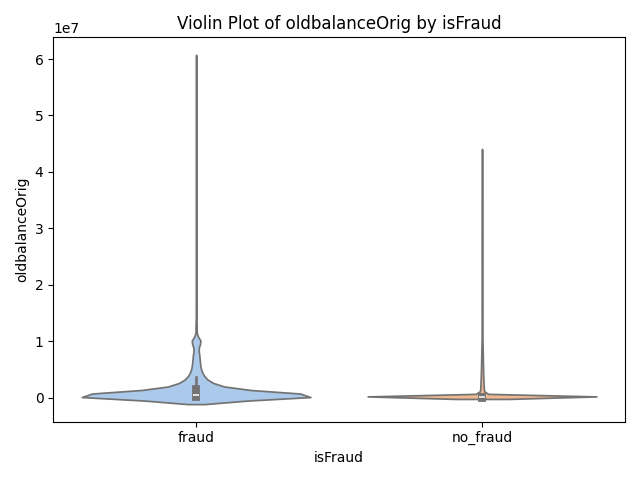

In [47]:
filename = 'violinplot_oldbalanceOrig_vs_fraud.png'
plot_filepath = os.path.join(images_directory, filename)

if not os.path.isfile(plot_filepath):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='isFraud', y='oldbalanceOrig', data=data, palette='pastel')
    plt.title('Violin Plot of oldbalanceOrig by isFraud')
    plt.tight_layout()

    plt.savefig(plot_filepath)
    plt.close() 

Image(filename=plot_filepath)

Observations: 

- The fraud violin plot shows much more outliers. The variability is very high.

- There is a small bump in the fraudulent transactions for the amount of 10M. Do fraudsters target those accounts?

### Additional statistics

In [48]:
oldbalanceorig_0 = data[data['oldbalanceOrig'] == 0]
oldbalanceorig_0

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
29,1,PAYMENT,9920.519531,C764826684,0.0,0.0,M1940055334,0.000,0.000,no_fraud,1,1.000-10.000
30,1,PAYMENT,3448.919922,C2103763750,0.0,0.0,M335107734,0.000,0.000,no_fraud,1,1.000-10.000
31,1,PAYMENT,4206.839844,C215078753,0.0,0.0,M1757317128,0.000,0.000,no_fraud,1,1.000-10.000
32,1,PAYMENT,5885.560059,C840514538,0.0,0.0,M1804441305,0.000,0.000,no_fraud,1,1.000-10.000
33,1,PAYMENT,5307.879883,C1768242710,0.0,0.0,M1971783162,0.000,0.000,no_fraud,1,1.000-10.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6356052,709,CASH_OUT,123403.109375,C1054278487,0.0,0.0,C1948756721,606875.625,730278.750,no_fraud,30,100.000-1.000.000
6356244,709,PAYMENT,14499.400391,C1009494758,0.0,0.0,M840318507,0.000,0.000,no_fraud,30,10.000-100.000
6362461,730,CASH_OUT,0.000000,C729003789,0.0,0.0,C1388096959,1008609.500,1008609.500,fraud,31,0-1.000
6362463,730,CASH_OUT,0.000000,C2088151490,0.0,0.0,C1156763710,0.000,0.000,fraud,31,0-1.000


In [49]:
oldbalanceorig_0_fraud = oldbalanceorig_0[oldbalanceorig_0['isFraud'] == 'fraud']
oldbalanceorig_0_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
724,1,CASH_OUT,4.160013e+05,C749981943,0.0,0.0,C667346055,102.000,9.291620e+06,fraud,1,100.000-1.000.000
14861,8,CASH_OUT,1.817281e+05,C2102265902,0.0,0.0,C789014007,11397.000,1.844778e+05,fraud,1,100.000-1.000.000
25875,8,TRANSFER,1.078014e+06,C1026280121,0.0,0.0,C277510102,0.000,9.707497e+05,fraud,1,1.000.000-10.000.000
77745,10,CASH_OUT,2.779709e+05,C489647033,0.0,0.0,C571514738,0.000,2.779709e+05,fraud,1,100.000-1.000.000
138559,11,TRANSFER,1.933921e+06,C1706582969,0.0,0.0,C461905695,1283762.875,3.217684e+06,fraud,1,1.000.000-10.000.000


In [50]:
oldbalanceorig_0_no_fraud = oldbalanceorig_0[oldbalanceorig_0['isFraud'] == 'no_fraud']
oldbalanceorig_0_no_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
29,1,PAYMENT,9920.519531,C764826684,0.0,0.0,M1940055334,0.0,0.0,no_fraud,1,1.000-10.000
30,1,PAYMENT,3448.919922,C2103763750,0.0,0.0,M335107734,0.0,0.0,no_fraud,1,1.000-10.000
31,1,PAYMENT,4206.839844,C215078753,0.0,0.0,M1757317128,0.0,0.0,no_fraud,1,1.000-10.000
32,1,PAYMENT,5885.560059,C840514538,0.0,0.0,M1804441305,0.0,0.0,no_fraud,1,1.000-10.000
33,1,PAYMENT,5307.879883,C1768242710,0.0,0.0,M1971783162,0.0,0.0,no_fraud,1,1.000-10.000


In [51]:
print(f'The amount of the old balances with 0€ is: {len(oldbalanceorig_0)}')
print(f'The percentage of the old balances with 0€ is: {(len(oldbalanceorig_0)/len(data)*100):.2f}%')

The amount of the old balances with 0€ is: 2102449
The percentage of the old balances with 0€ is: 33.04%


In [52]:

print(f'The amount of the fraudulent transactions from accounts with 0€ is: {len(oldbalanceorig_0_fraud)}')
print(f'The amount of the NON fraudulent transactions from accounts with 0€ is: {len(oldbalanceorig_0_no_fraud)}')
print(f'The percentage of such NON fraudulent transactions with 0€ is: {(len(oldbalanceorig_0_no_fraud)/len(oldbalanceorig_0)*100):.4f}%')

The amount of the fraudulent transactions from accounts with 0€ is: 41
The amount of the NON fraudulent transactions from accounts with 0€ is: 2102408
The percentage of such NON fraudulent transactions with 0€ is: 99.9980%


Observations:

The 33% of accounts with transactions had balance = 0€ in the origin. From those, the vast majority are non fraudulent. I need more information here because I don't understand, taking into consideration that we don't have the type CREDIT, how users can operate with their accounts. Are they mistakes? 

## newbalanceOrig vs. isFraud

### Statistical tests

In [53]:
group1 = data[data['isFraud'] == 'fraud']['newbalanceOrig']
group2 = data[data['isFraud'] == 'no_fraud']['newbalanceOrig']

stat, p_value = mannwhitneyu(group1, group2)

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p_value}")

Mann-Whitney U Statistic: 15460387631.5
P-Value: 0.0


- p-value = 0 so there is a significative statistical difference of 'newbalanceOrig' between the two catories of 'isFraud'. The variable 'newbalanceOrig' behaves differently in each group.

- Mann-Whitney U Statistic: 15460387631.5. The range between both groups is very huge. 

### Summary stats

In [54]:
data.groupby('isFraud')['newbalanceOrig'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
fraud,8213.0,192392.6250,1965666.5,0.0,0.0,0.0,0.000000,49585040.0
no_fraud,6354407.0,855970.1875,2924987.0,0.0,0.0,0.0,144730.742188,43686616.0


Obsrvations:

Have you seen the quantiles? Fraudulent transactions are 0 until the 75th and then it reaches an even higher maximum value than the non fraudulent transactions. 

### Visualization

In [55]:
contingency_table = pd.crosstab(data['newbalanceOrig'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
newbalanceOrig,,
0.00,8053,3601513
0.01,0,1
0.03,0,1
0.05,0,1
0.12,0,1
...,...,...
41690844.00,0,1
43673804.00,0,1
43686616.00,0,1


Observations: 

 - Again, as in oldbalanceOrig, 1.000000e+07 is a commonly used balance in fraud transactions. 

In [56]:
contingency_table[contingency_table['fraud'] > 1]

isFraud,fraud,no_fraud
newbalanceOrig,,
0.000000e+00,8053,3601513
3.538742e+05,2,0
5.366244e+05,2,0
1.343002e+06,2,0
2.542664e+06,2,0
3.171086e+06,2,0
3.441042e+06,2,0
3.576297e+06,2,0
4.892193e+06,2,0


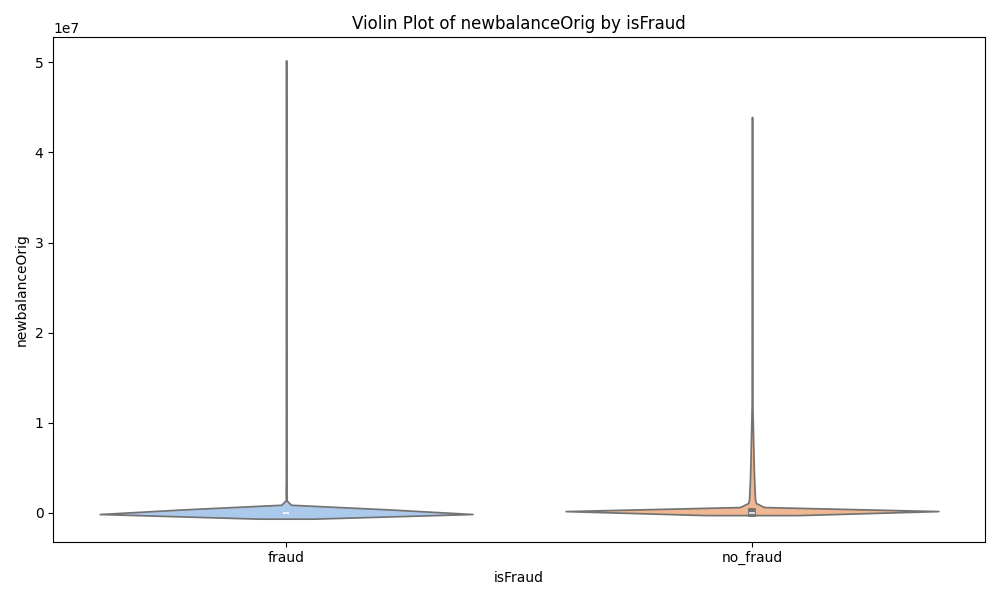

In [57]:
filename = 'violinplot_newbalanceOrig_vs_fraud.png'
plot_filepath = os.path.join(images_directory, filename)

if not os.path.isfile(plot_filepath):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='isFraud', y='newbalanceOrig', data=data, palette='pastel')
    plt.title('Violin Plot of newbalanceOrig by isFraud')
    plt.tight_layout()

    plt.savefig(plot_filepath)
    plt.close()  

Image(filename=plot_filepath)

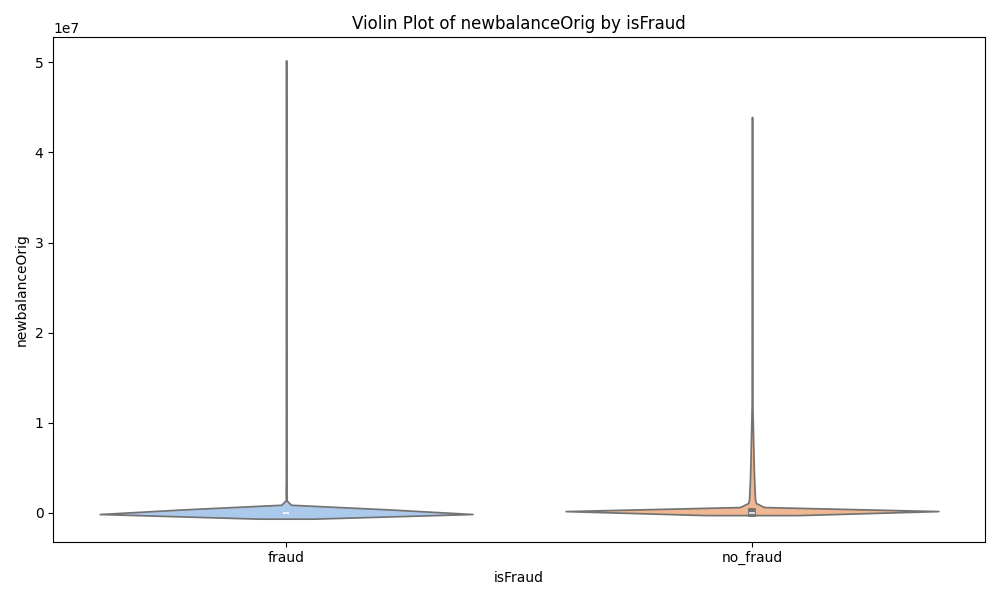

In [58]:
filename = 'violinplot_newbalanceOrig_vs_fraud.png'
plot_filepath = os.path.join(images_directory, filename)

if not os.path.isfile(plot_filepath):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='isFraud', y='newbalanceOrig', data=data, palette='pastel')
    plt.title('Violin Plot of newbalanceOrig by isFraud')
    plt.tight_layout()

    plt.savefig(plot_filepath)
    plt.close()  

Image(filename=plot_filepath)

Observations:

Outliers here are very extreme.

### Additional statistics

In [59]:
newbalance_0 = data[data['newbalanceOrig'] == 0]

estudiar los balances con 0 euros 
balances con fraud puedo sacar algo de ahi?
what about create a column that is the difference between oldbalance and new balance?

## oldbalanceDest vs. isFraud

### Statistical tests

In [60]:
group1 = data[data['isFraud'] == 'fraud']['oldbalanceDest']
group2 = data[data['isFraud'] == 'no_fraud']['oldbalanceDest']

stat, p_value = mannwhitneyu(group1, group2)

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p_value}")

Mann-Whitney U Statistic: 19183643293.5
P-Value: 0.0


- p-value = 0 so there is a significative statistical difference of 'oldbalanceDest' between the two catories of 'isFraud'. The variable 'oldbalanceDest' behaves differently in each group.

- Mann-Whitney U Statistic: 19183643293.5. The range between both groups is very huge. 

### Summary stats

In [61]:
data.groupby('isFraud')['oldbalanceDest'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
fraud,8213.0,5.442496e+05,3336420.75,0.0,0.0,0.000000,147828.65625,236230512.0
no_fraud,6354407.0,1.101422e+06,3399201.75,0.0,0.0,133311.796875,944144.59375,356015904.0


Observations:

It's surprising the how much the fraudsters are actually using accounts with balance = 0€ in the destination (even the median is still 0!). Are those accounts that receive the money from fraudsters and that is the reason why they have no money? Could that be used as an alert? 

### Visualization

In [62]:
contingency_table = pd.crosstab(data['oldbalanceDest'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
oldbalanceDest,,
0.000000e+00,5351,2699037
1.000000e-02,0,1
3.000000e-02,0,1
1.300000e-01,0,1
3.300000e-01,0,1
...,...,...
3.551855e+08,0,1
3.553805e+08,0,1
3.553814e+08,0,1


In [63]:
contingency_table[contingency_table['fraud'] > 1]

isFraud,fraud,no_fraud
oldbalanceDest,,
0.0,5351,2699037


Observations: 

 - Again, as in the previous balances, 1.000000e+07 is a commonly used balances in fraud transactions records

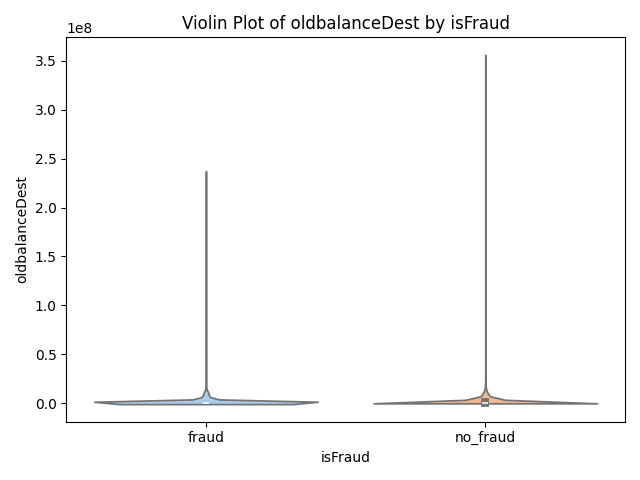

In [64]:
filename = 'violinplot_oldbalanceDest_vs_fraud.png'
plot_filepath = os.path.join(images_directory, filename)

if not os.path.isfile(plot_filepath):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='isFraud', y='oldbalanceDest', data=data, palette='pastel')
    plt.title('Violin Plot of oldbalanceDest by isFraud')
    plt.tight_layout()

    plt.savefig(plot_filepath)
    plt.close()  

Image(filename=plot_filepath)

Observations:

- Both violin plots are extremely flat but it's clear that the variability in balances for non fraudulent transactions is higher.

### Additional statistics

In [65]:
oldbalancedest_0 = data[data['oldbalanceDest'] == 0]
oldbalancedest_0

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.0,0.000,no_fraud,1,1.000-10.000
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.0,0.000,no_fraud,1,1.000-10.000
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.0,0.000,fraud,1,0-1.000
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.0,0.000,no_fraud,1,10.000-100.000
5,1,PAYMENT,7.817710e+03,C90045638,53860.000,46042.289062,M573487274,0.0,0.000,no_fraud,1,1.000-10.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362612,743,TRANSFER,1.258819e+06,C1531301470,1258818.875,0.000000,C1470998563,0.0,0.000,fraud,31,1.000.000-10.000.000
6362614,743,TRANSFER,3.396821e+05,C2013999242,339682.125,0.000000,C1850423904,0.0,0.000,fraud,31,100.000-1.000.000
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.0,339682.125,fraud,31,100.000-1.000.000
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.0,0.000,fraud,31,1.000.000-10.000.000


In [66]:
oldbalancedest_0_fraud = oldbalancedest_0[oldbalancedest_0['isFraud'] == 'fraud']
oldbalancedest_0_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,fraud,1,0-1.000
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,fraud,1,1.000-10.000
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,fraud,1,10.000-100.000
969,1,TRANSFER,1277212.75,C1334405552,1277212.75,0.0,C431687661,0.0,0.00,fraud,1,1.000.000-10.000.000
970,1,CASH_OUT,1277212.75,C467632528,1277212.75,0.0,C716083600,0.0,2444985.25,fraud,1,1.000.000-10.000.000


In [67]:
oldbalancedest_0_no_fraud = oldbalancedest_0[oldbalancedest_0['isFraud'] == 'no_fraud']
oldbalancedest_0_no_fraud

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.000000,no_fraud,1,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.000000,no_fraud,1,1.000-10.000
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.000000,no_fraud,1,10.000-100.000
5,1,PAYMENT,7817.709961,C90045638,53860.0,46042.289062,M573487274,0.0,0.000000,no_fraud,1,1.000-10.000
6,1,PAYMENT,7107.770020,C154988899,183195.0,176087.234375,M408069119,0.0,0.000000,no_fraud,1,1.000-10.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362316,718,PAYMENT,1022.909973,C1203084509,12.0,0.000000,M675916850,0.0,0.000000,no_fraud,30,1.000-10.000
6362318,718,PAYMENT,4109.569824,C673558958,5521.0,1411.430054,M1126011651,0.0,0.000000,no_fraud,30,1.000-10.000
6362319,718,PAYMENT,8634.290039,C642813806,518802.0,510167.718750,M747723689,0.0,0.000000,no_fraud,30,1.000-10.000
6362320,718,CASH_OUT,159188.218750,C691808084,3859.0,0.000000,C1818183087,0.0,159188.218750,no_fraud,30,100.000-1.000.000


In [68]:
print(f'The amount of the old balances with 0€ is: {len(oldbalancedest_0)}')
print(f'The percentage of the old balances with 0€ is: {(len(oldbalancedest_0)/len(data)*100):.2f}%')

The amount of the old balances with 0€ is: 2704388
The percentage of the old balances with 0€ is: 42.50%


In [69]:

print(f'The amount of the fraudulent transactions from accounts with 0€ is: {len(oldbalancedest_0_fraud)}')
print(f'The amount of the NON fraudulent transactions from accounts with 0€ is: {len(oldbalancedest_0_no_fraud)}')
print(f'The percentage of such NON fraudulent transactions with 0€ is: {(len(oldbalancedest_0_no_fraud)/len(oldbalancedest_0)*100):.4f}%')

The amount of the fraudulent transactions from accounts with 0€ is: 5351
The amount of the NON fraudulent transactions from accounts with 0€ is: 2699037
The percentage of such NON fraudulent transactions with 0€ is: 99.8021%


Observations:

The 42.5% of accounts with transactions had balance = 0€ in the destination. From those, the vast majority are non fraudulent. I need more information here because I don't understand, how can some transactions be payments but we don't see the amount being translated to the destination?


## newbalanceDest vs. isFraud

### Statistical tests

In [70]:
group1 = data[data['isFraud'] == 'fraud']['newbalanceDest']
group2 = data[data['isFraud'] == 'no_fraud']['newbalanceDest']

stat, p_value = mannwhitneyu(group1, group2)

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p_value}")

Mann-Whitney U Statistic: 23982267534.5
P-Value: 4.847058792178127e-39


- p-value = 4.847058792178127e-39. It's not zero like the previous balances but still it's too low to be considered. So I can say that there is a significative statistical difference of 'newbalanceDest' between the two catories of 'isFraud'. The variable 'newbalanceDest' behaves differently in each group.

- Mann-Whitney U Statistic: 23982267534.5. The range between both groups is very huge. 

### Summary stats

In [71]:
data.groupby('isFraud')['newbalanceDest'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
fraud,8213.0,1279707.625,3908816.50,0.0,0.0,4676.419922,1058725.250,236726496.0
no_fraud,6354407.0,1224926.625,3673815.75,0.0,0.0,214881.703125,1111975.375,356179264.0


Obervations:

- Means are very close.
- Fraud transactions tend to have a higher amount since the 50th quantile is much smaller than the no_fraud transactions. The range is also lower.

### Visualisation

In [72]:
contingency_table = pd.crosstab(data['newbalanceDest'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
newbalanceDest,,
0.000000e+00,4091,2435342
1.000000e-02,0,1
3.300000e-01,0,1
1.390000e+00,0,1
1.640000e+00,0,1
...,...,...
3.553805e+08,0,1
3.553814e+08,0,1
3.555534e+08,0,2


In [73]:
contingency_table[contingency_table['fraud'] > 1]

isFraud,fraud,no_fraud
newbalanceDest,,
0.000000e+00,4091,2435342
1.279058e+05,2,0
4.292574e+05,2,1
1.064996e+06,2,0
1.165188e+06,2,1
1.000000e+07,53,0


Observations: 

 -  1.000000e+07 appears as a very important balance that is common in fraud çtransactions with balances

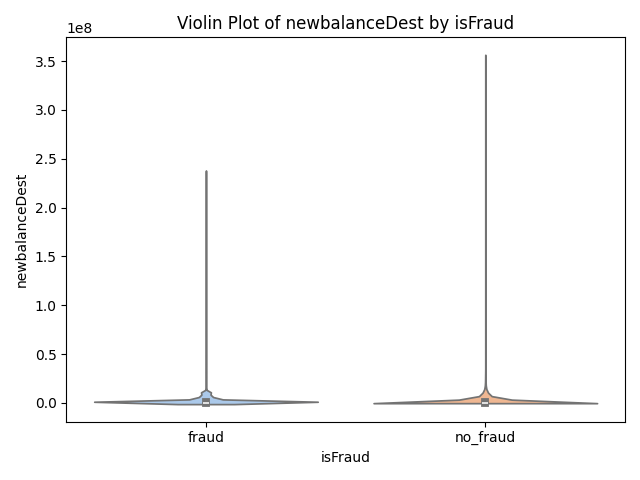

In [74]:
filename = 'violinplot_newbalanceDest_vs_fraud.png'
plot_filepath = os.path.join(images_directory, filename)

if not os.path.isfile(plot_filepath):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='isFraud', y='newbalanceDest', data=data, palette='pastel')
    plt.title('Violin Plot of newbalanceDest by isFraud')
    plt.tight_layout()

    plt.savefig(plot_filepath)
    plt.close()  

Image(filename=plot_filepath)

Observations:

The distribution of this variable is very similar to the distribution of the variable 'oldbalanceDest'

### Additional statistics

In [75]:
newbalancedest_0 = data[data['newbalanceDest'] == 0]
newbalancedest_0

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9.839640e+03,C1231006815,1.701360e+05,160296.359375,M1979787155,0.0,0.0,no_fraud,1,1.000-10.000
1,1,PAYMENT,1.864280e+03,C1666544295,2.124900e+04,19384.720703,M2044282225,0.0,0.0,no_fraud,1,1.000-10.000
2,1,TRANSFER,1.810000e+02,C1305486145,1.810000e+02,0.000000,C553264065,0.0,0.0,fraud,1,0-1.000
3,1,CASH_OUT,1.810000e+02,C840083671,1.810000e+02,0.000000,C38997010,21182.0,0.0,fraud,1,0-1.000
4,1,PAYMENT,1.166814e+04,C2048537720,4.155400e+04,29885.859375,M1230701703,0.0,0.0,no_fraud,1,10.000-100.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,6.341699e+04,C778071008,6.341699e+04,0.000000,C1812552860,0.0,0.0,fraud,31,10.000-100.000
6362612,743,TRANSFER,1.258819e+06,C1531301470,1.258819e+06,0.000000,C1470998563,0.0,0.0,fraud,31,1.000.000-10.000.000
6362614,743,TRANSFER,3.396821e+05,C2013999242,3.396821e+05,0.000000,C1850423904,0.0,0.0,fraud,31,100.000-1.000.000
6362616,743,TRANSFER,6.311410e+06,C1529008245,6.311410e+06,0.000000,C1881841831,0.0,0.0,fraud,31,1.000.000-10.000.000


In [76]:
newbalancedest_0_fraud = newbalancedest_0[newbalancedest_0['isFraud'] == 'fraud']
newbalancedest_0_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,fraud,1,0-1.000
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,fraud,1,0-1.000
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,fraud,1,1.000-10.000
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,fraud,1,1.000-10.000
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,fraud,1,10.000-100.000


In [77]:
newbalancedest_0_no_fraud = newbalancedest_0[newbalancedest_0['isFraud'] == 'no_fraud']
newbalancedest_0_no_fraud

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud,1,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud,1,1.000-10.000
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud,1,10.000-100.000
5,1,PAYMENT,7817.709961,C90045638,53860.0,46042.289062,M573487274,0.0,0.0,no_fraud,1,1.000-10.000
6,1,PAYMENT,7107.770020,C154988899,183195.0,176087.234375,M408069119,0.0,0.0,no_fraud,1,1.000-10.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362312,718,PAYMENT,8178.009766,C1213413071,11742.0,3563.989990,M1112540487,0.0,0.0,no_fraud,30,1.000-10.000
6362314,718,PAYMENT,17841.230469,C1045048098,10182.0,0.000000,M1878955882,0.0,0.0,no_fraud,30,10.000-100.000
6362316,718,PAYMENT,1022.909973,C1203084509,12.0,0.000000,M675916850,0.0,0.0,no_fraud,30,1.000-10.000
6362318,718,PAYMENT,4109.569824,C673558958,5521.0,1411.430054,M1126011651,0.0,0.0,no_fraud,30,1.000-10.000


In [78]:
print(f'The amount of the old balances with 0€ is: {len(newbalancedest_0)}')
print(f'The percentage of the old balances with 0€ is: {(len(newbalancedest_0)/len(data)*100):.2f}%')

The amount of the old balances with 0€ is: 2439433
The percentage of the old balances with 0€ is: 38.34%


In [79]:

print(f'The amount of the fraudulent transactions from accounts with 0€ is: {len(newbalancedest_0_fraud)}')
print(f'The amount of the NON fraudulent transactions from accounts with 0€ is: {len(newbalancedest_0_no_fraud)}')
print(f'The percentage of such NON fraudulent transactions with 0€ is: {(len(newbalancedest_0_no_fraud)/len(newbalancedest_0)*100):.4f}%')

The amount of the fraudulent transactions from accounts with 0€ is: 4091
The amount of the NON fraudulent transactions from accounts with 0€ is: 2435342
The percentage of such NON fraudulent transactions with 0€ is: 99.8323%


Observations:

Both oldbalanceDest and newbalanceDest variables have very similar values and percentages related to values = 0€

## Creating variables for difference of balances 

In [80]:
data['diffbalanceOrig'] = data['newbalanceOrig'] - data['oldbalanceOrig']
data['diffbalanceDest'] = data['newbalanceDest'] - data['oldbalanceDest']

In [81]:
data

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,diffbalanceOrig,diffbalanceDest
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,no_fraud,1,1.000-10.000,-9.839641e+03,0.000
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,no_fraud,1,1.000-10.000,-1.864279e+03,0.000
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,fraud,1,0-1.000,-1.810000e+02,0.000
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,fraud,1,0-1.000,-1.810000e+02,-21182.000
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,no_fraud,1,10.000-100.000,-1.166814e+04,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,fraud,31,100.000-1.000.000,-3.396821e+05,339682.125
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,fraud,31,1.000.000-10.000.000,-6.311410e+06,0.000
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,fraud,31,1.000.000-10.000.000,-6.311410e+06,6311409.000
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,fraud,31,100.000-1.000.000,-8.500025e+05,0.000


## Correlation

In [82]:
data.dtypes

step                  int16
type               category
amount              float32
nameOrig           category
oldbalanceOrig      float32
newbalanceOrig      float32
nameDest           category
oldbalanceDest      float32
newbalanceDest      float32
isFraud            category
day_of_month           int8
amount_range       category
diffbalanceOrig     float32
diffbalanceDest     float32
dtype: object

In [83]:
numerical_cols = data.select_dtypes(include=['float32', 'int16', 'int8']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns



In [84]:
pickle_filename = 'correlation_matrix.pkl'
pickle_filepath = os.path.join(pickle_directory, pickle_filename)

is_cached = False

try:
    correlation_matrix = load_from_pickle(pickle_filepath)
    is_cached = True
except FileNotFoundError:
    is_cached = False

if is_cached:
    print("The correlation matrix is stored in cache")
else:
    print("Correlation matrix not found. Calculating...")
    
    encoder = ce.TargetEncoder(cols=categorical_cols)
    target_col = numerical_cols[0]
    
    df_encoded = encoder.fit_transform(data, data[target_col])
    correlation_matrix = df_encoded.corr()

    save_to_pickle(correlation_matrix, pickle_filepath)

correlation_matrix


The correlation matrix is stored in cache


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
step,1.000000,0.013760,0.022373,0.999264,-0.010058,-0.010299,0.603271,0.027665,0.025888,0.031578,0.999586,0.033385
type,0.013760,1.000000,0.117539,0.013746,0.152440,0.159545,0.047891,-0.027514,-0.015565,0.006886,0.013283,0.101450
amount,0.022373,0.117539,1.000000,0.022360,-0.002762,-0.007861,-0.063719,0.294137,0.459304,0.076688,0.023473,0.495951
nameOrig,0.999264,0.013746,0.022360,1.000000,-0.010063,-0.010305,0.602818,0.027639,0.025864,0.031563,0.998849,0.033366
oldbalanceOrig,-0.010058,0.152440,-0.002762,-0.010063,1.000000,0.998803,-0.075316,0.066243,0.042029,0.010154,-0.009940,-0.000797
newbalanceOrig,-0.010299,0.159545,-0.007861,-0.010305,0.998803,1.000000,-0.076943,0.067812,0.041837,-0.008148,-0.010181,-0.009221
nameDest,0.603271,0.047891,-0.063719,0.602818,-0.075316,-0.076943,1.000000,-0.257550,-0.250388,0.021638,0.601662,-0.004134
oldbalanceDest,0.027665,-0.027514,0.294137,0.027639,0.066243,0.067812,-0.257550,1.000000,0.976569,-0.005885,0.027878,0.120624
newbalanceDest,0.025888,-0.015565,0.459304,0.025864,0.042029,0.041837,-0.250388,0.976569,1.000000,0.000535,0.026274,0.219529
isFraud,0.031578,0.006886,0.076688,0.031563,0.010154,-0.008148,0.021638,-0.005885,0.000535,1.000000,0.032425,0.054086


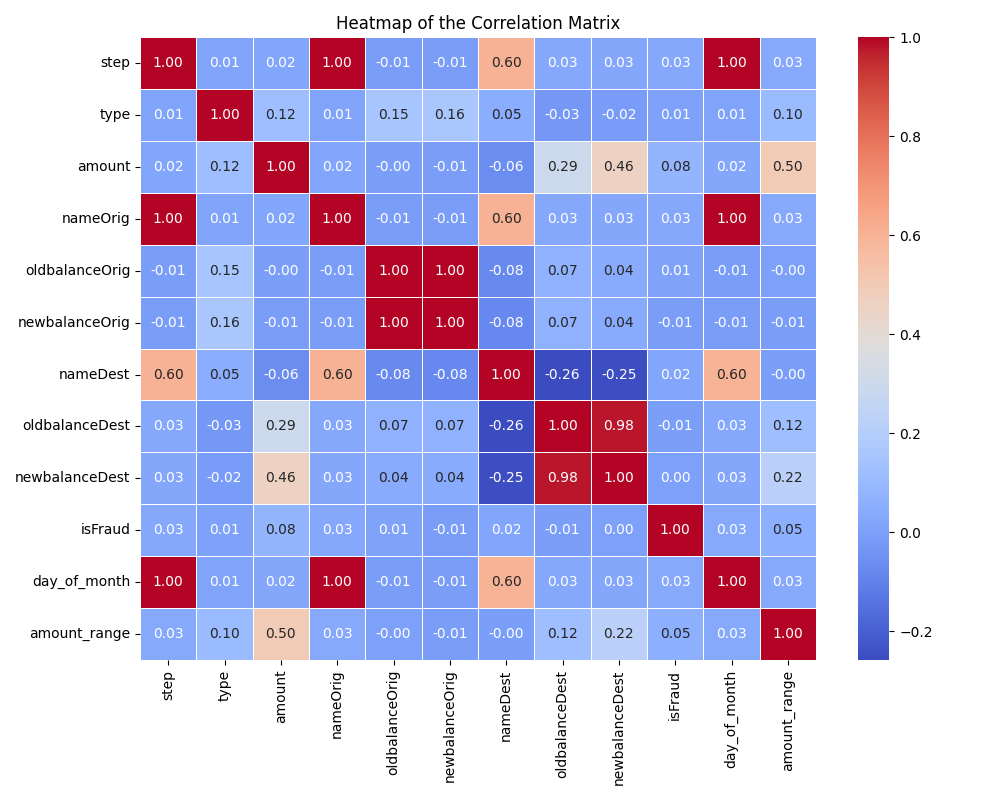

In [85]:
heatmap_filename = 'heatmap_correlation_matrix.png'
heatmap_filepath = os.path.join(images_directory, heatmap_filename)

if not os.path.isfile(heatmap_filepath):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Heatmap of the Correlation Matrix')
    plt.tight_layout()
    plt.savefig(heatmap_filepath)
    plt.close()  

Image(filename=heatmap_filepath)

In [86]:

# threshold = 0.9

# high_correlation_pairs = [(col1, col2) for col1 in correlation.columns for col2 in correlation.columns 
#                           if col1 != col2 and abs(correlation.loc[col1, col2]) > threshold]

# variables_to_remove = set()
# for col1, col2 in high_correlation_pairs:
#     if col1 not in variables_to_remove and col2 not in variables_to_remove:
#         variables_to_remove.add(col2)

# print(f"Variables to remove due to high correlation: {variables_to_remove}")

# reduced_df = df_encoded.drop(columns=variables_to_remove)

# reduced_correlation = reduced_df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(reduced_correlation, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
# plt.title('Heatmap of the Reduced Correlation Matrix')
# plt.show()

In [87]:
data

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,diffbalanceOrig,diffbalanceDest
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,no_fraud,1,1.000-10.000,-9.839641e+03,0.000
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,no_fraud,1,1.000-10.000,-1.864279e+03,0.000
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,fraud,1,0-1.000,-1.810000e+02,0.000
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,fraud,1,0-1.000,-1.810000e+02,-21182.000
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,no_fraud,1,10.000-100.000,-1.166814e+04,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,fraud,31,100.000-1.000.000,-3.396821e+05,339682.125
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,fraud,31,1.000.000-10.000.000,-6.311410e+06,0.000
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,fraud,31,1.000.000-10.000.000,-6.311410e+06,6311409.000
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,fraud,31,100.000-1.000.000,-8.500025e+05,0.000


In [89]:
data.to_parquet('../data/silver/df_fraud_bivar.parquet', engine= 'fastparquet')